In [1]:
import sys
import cv2
import os
from sys import platform
import matplotlib.pyplot as plt
import numpy as np
import math



In [2]:
dir_path = '/root/final/main'
sys.path.append('/root/final/main')
sys.path.append('/usr/local/python/openpose')
from openpose import *

In [3]:
params = dict()
params["logging_level"] = 3
params["output_resolution"] = "-1x-1"
params["net_resolution"] = "-1x368"
params["model_pose"] = "BODY_25"
params["alpha_pose"] = 0.6
params["scale_gap"] = 0.25
params["scale_number"] = 1
params["render_threshold"] = 0.05
# If GPU version is built, and multiple GPUs are available, set the ID here
params["num_gpu"] = 1
params["num_gpu_start"] = 1
params["disable_blending"] = False
# Ensure you point to the correct path where models are located
params["default_model_folder"] = "/root/final/openpose/models/"
# Construct OpenPose object allocates GPU memory
openpose = OpenPose(params)

In [4]:
def get_md(point1 , point2):
    # return Manhattan Distance of point1 and point2
    # point1 and point2 are list
    test1 = np.array(point1)
    test2 = np.array(point2)
    return np.sqrt(np.sum(np.square(test1-test2)))


def get_angle(vec1,vec2):
    # return the angle of vector one to vector two 
    # negative when the vec2 is in the clockwise of vec1
    #vec1 and vec2 are list
    x = np.array(vec1)
    y = np.array(vec2)
    #lenth
    Lx = np.sqrt(x.dot(x))
    Ly = np.sqrt(y.dot(y))
    cos_angle = x.dot(y)/(Lx*Ly)
    angle = np.arccos(cos_angle)
    angle2 = angle*360/2/np.pi
    crossdd = np.cross(x,y)
    if (crossdd <= 0):
        return angle2
    else:
        return -angle2

In [5]:
test1 = "barbell_curls_true"
test2 = "barbell_curls_wrong"

test3 = "barbell_curls_test1"
test4 = "barbell_curls_test2"
test5 = "barbell_curls_test3"
# the path of the video
input_path = "/root/final/main/test_video/test_video1/"
input_video = test2
input_type = ".mp4"
cap = cv2.VideoCapture(input_path+input_video+input_type)
# create the output folder
folder = os.path.exists("output_video/"+ input_video) 
if not folder:                  
    os.makedirs("output_video/"+ input_video) 

count = 0
num_count = 0
theta1_list = [] 
theta2_list = []
theta3_list = []
feedback = [] 
index_count = [] 
while(cap.isOpened()):
    ret, frame = cap.read() 
    count+=1
    if frame is None:
        break;
    if count% 3==0 :
        num_count+=1
        # following 2 lines are used for test
        frame=cv2.transpose(frame)
        frame=cv2.flip(frame,1)
        #print(frame.shape)
        #plt.imshow(frame)
        #plt.show() 
        #break
        #return the keypoints and rendered output images
        keypoints, output_image = openpose.forward(frame, True)
        # Print the human pose keypoints, i.e., a [#people x #keypoints x 3]-dimensional numpy object with the keypoints of all the people on that image
        # store the rendered image
        #print(frame.shape)
        #plt.imshow(output_image)
        #plt.show() 
        temp_name = str(count)
        while(len(temp_name)!=4):
            temp_name = "0"+temp_name
        store_name = "output_video/"+ input_video + "/" + temp_name+".jpg"
        index_count.append(store_name)
        #print(store_name)
        cv2.imwrite(store_name, output_image);
        # deal with the keypoints
        [people_num , point_num, channel] = keypoints.shape
        # to choose the domaint skleton
        #if (people_num != 1):
        #    best_index = 0
        #    best_dist = 0 
        #    for index in range(people_num):
        #        point1 = [keypoints[index,1,0] , keypoints[index,1,1]  ]
        #        point8 = [keypoints[index,8,0] , keypoints[index,8,1]  ] 
        #        test_cof =math.ceil( keypoints[index,1,0] )& math.ceil(keypoints[index,8,0]) 
        #        dist = get_md(point1,point8)
        #        if (dist > best_dist) & test_cof:
        #            best_index = index
        #            best_dist = dist
        #    keypoint = keypoints[best_index,:,:]
        #else:
        #    keypoint = keypoints
        keypoint = keypoints[0,:,:]
        keypoint = np.squeeze(keypoint)
        # here determine whether is right or left hand
        right_hand = np.array([ math.ceil(keypoint[2,2]) ,math.ceil(keypoint[3,2]) ,math.ceil(keypoint[4,2]) ])
        left_hand = np.array([ math.ceil(keypoint[5,2]) ,math.ceil(keypoint[6,2]) ,math.ceil(keypoint[7,2]) ])
        right_confidence  = keypoint[2,2] + keypoint[3,2] + keypoint[4,2]
        left_confidence = keypoint[5,2] + keypoint[6,2] + keypoint[7,2]
        #print(right_hand,' right hand')
        #print(left_hand,' left hand')
        #print( keypoint[0,2,2] , keypoint[0,3,2] ,keypoint[0,4,2] , ' right confidence')
        #print( keypoint[0,5,2] , keypoint[0,6,2] ,keypoint[0,7,2] , ' left confidence')
        output_flag = 0 
        side = 'right'
        if ((np.sum(right_hand) == 3) & (right_confidence >= left_confidence) ):
            side = 'right'
            output_flag = 1
            shoulder_point =  [keypoint[2,0] , keypoint[2,1] ] 
            elbow_point =  [keypoint[3,0] , keypoint[3,1]  ] 
            wrist_point =  [keypoint[4,0] , keypoint[4,1]  ]  
        elif ((np.sum(left_hand) == 3) & (right_confidence < left_confidence) ):
            side = 'left'
            output_flag = 1
            shoulder_point =  [keypoint[5,0] , keypoint[5,1] ] 
            elbow_point =   [keypoint[6,0] , keypoint[6,1]  ] 
            wrist_point =  [keypoint[7,0] , keypoint[7,1]  ]
        else:
            side = 'right'
            output_flag = 1
            shoulder_point =  [keypoint[2,0] , keypoint[2,1] ] 
            elbow_point =  [keypoint[3,0] , keypoint[3,1]  ] 
            wrist_point =  [keypoint[4,0] , keypoint[4,1]  ]              
        #print(store_name, side)
        neck_point = [keypoint[1,0] , keypoint[1,1] ]
        midhip_point = [keypoint[8,0] , keypoint[8,1] ]        
        # first calculate the angle between the line(neck,midhip) with vertical
        vec1 = np.array(midhip_point) - np.array(neck_point)
        vec2 = np.array([neck_point[0],neck_point[1]+2]) -np.array(neck_point)
        theta1= get_angle( vec1 ,vec2 )
        if side == 'right':
            theta1_list.append(-theta1)
        else:
            theta1_list.append(theta1)
        #print(theta1)
        
        # then calculate the angle between the line(elbow,wrist) with vertical
        vec1 = np.array(wrist_point) - np.array(elbow_point)
        vec2 = np.array([elbow_point[0],elbow_point[1]+2]) -np.array(elbow_point)
        theta2= get_angle( vec1 ,vec2 )
        if side == 'right':
            theta2_list.append(-theta2)
        else:
            theta2_list.append(theta2)
        #print(theta2) 
        
        # next calculate the angle between the line(shoulder , elbow) with line(neck , midhip)
        vec1 = np.array(midhip_point) - np.array(neck_point) 
        vec2 = np.array(elbow_point) - np.array(shoulder_point)
        theta3= get_angle( vec1 ,vec2 )
        if side == 'right':
            theta3_list.append(-theta3)
        else:
            theta3_list.append(theta3)
        #print(theta3)
print(count)

506


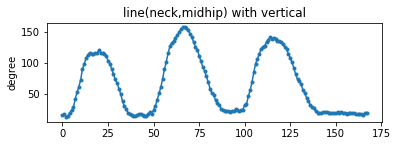

In [6]:
# post processing for mismatching
negative_count = 0
positive_count = 0 
for x in theta2_list:
    if x > 0 :
        positive_count+=1
    else:
        negative_count+=1
if negative_count > positive_count:
    for index in range(len(theta2_list)):
        if theta2_list[index] > 0 :
            theta2_list[index] = - theta2_list[index]
else:
    for index in range(len(theta2_list)):
        if theta2_list[index] < 0 :
            theta2_list[index] = - theta2_list[index]    
        
x1 = range(0, len(theta2_list))
y1 = theta2_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, '.-')
plt.title('line(elbow,wrist) with vertical')
plt.ylabel('degree')

plt.show()

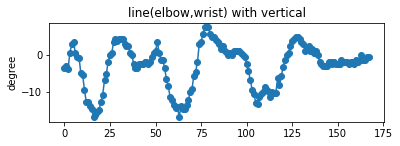

In [7]:
x1 = range(0, num_count)
y1 = theta1_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('line(elbow,wrist) with vertical')
plt.ylabel('degree')

plt.show()

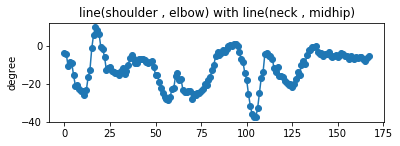

In [8]:
x1 = range(0, num_count)
y1 = theta3_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('line(shoulder , elbow) with line(neck , midhip)')
plt.ylabel('degree')

plt.show()

In [9]:
# try to deal with each action seperately
feedbacks = []
seperate_point = []


####
# to store the frame of wrong action
feedbacks_image = []
####
####
# to store the whole actions
whole_actions = []
####


import peakutils
theta2_list_temp = -np.array(theta2_list)
seperate_points = peakutils.indexes(theta2_list_temp, thres=0.01/max(theta2_list_temp), min_dist=30)
print('seperating points are:', seperate_points)
for index_x in range(0,len(seperate_points)-1):
    print(index_x)
    feedback_temp = ['None','None','None']
    feedback_image_temp = ['None','None','None']
    test_theta1_list =  theta1_list[ seperate_points[index_x] :  seperate_points[index_x+1] ]
    test_theta2_list =  theta2_list[ seperate_points[index_x] :  seperate_points[index_x+1] ]
    test_theta3_list =  theta3_list[ seperate_points[index_x] :  seperate_points[index_x+1] ]
    # store the action
    whole_actions.append(test_theta2_list )    
    # theta1_list
    # check whether your body fixed
    max_theta1 = max(test_theta1_list)
    min_theta1 = min(test_theta1_list)
    #print(max_theta1,min_theta1)
    if (max_theta1 - min_theta1 > 12):
        feedback_temp[0]=('Keep your body fixed! Do not shake!')
    
    # theta2_list
    max_theta2 = max(test_theta2_list)
    min_theta2 = min(test_theta2_list)
    #print( max_theta2, min_theta2 )
    max_index = theta2_list.index(max_theta2)
    if (max_theta2 >= 146):
        feedback_image_temp[1]=index_count[max_index]
        feedback_temp[1]=( 'Go up too much!, it is better to lower '+str(round(max_theta2 -146))+' degrees!' )   
    
    # theta3_list
    max_theta3 = max(test_theta3_list, key=abs)
    print(max_theta3)
    max_index = theta3_list.index(max_theta3)
    if (abs(max_theta3) > 20)  :
        feedback_image_temp[2]= index_count[max_index]
        feedback_temp[2]=('Keep your hands close to your body!')
    feedbacks.append(feedback_temp)
    feedbacks_image.append(feedback_image_temp)

seperating points are: [  2  39  92 165]
0
-26.028139964531505
1
-28.345814395213594
2
-37.493483335517084


In [10]:
print(feedbacks)
print(feedbacks_image)

[['Keep your body fixed! Do not shake!', 'None', 'Keep your hands close to your body!'], ['Keep your body fixed! Do not shake!', 'Go up too much!, it is better to lower 11.0 degrees!', 'Keep your hands close to your body!'], ['Keep your body fixed! Do not shake!', 'None', 'Keep your hands close to your body!']]
[['None', 'None', 'output_video/barbell_curls_wrong/0036.jpg'], ['None', 'output_video/barbell_curls_wrong/0204.jpg', 'output_video/barbell_curls_wrong/0174.jpg'], ['None', 'None', 'output_video/barbell_curls_wrong/0318.jpg']]


In the 1 turn, you have several problems:
Keep your body fixed! Do not shake!
 Keep your hands close to your body!


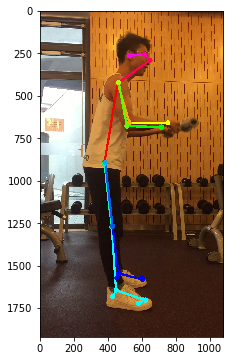

~~~~~~~~~~~~~~~~~~~~~~
In the 2 turn, you have several problems:
Keep your body fixed! Do not shake!
 Go up too much!, it is better to lower 11.0 degrees!


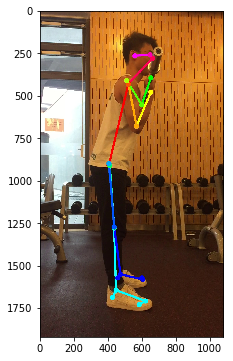

 Keep your hands close to your body!


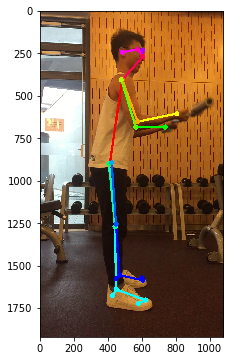

~~~~~~~~~~~~~~~~~~~~~~
In the 3 turn, you have several problems:
Keep your body fixed! Do not shake!
 Keep your hands close to your body!


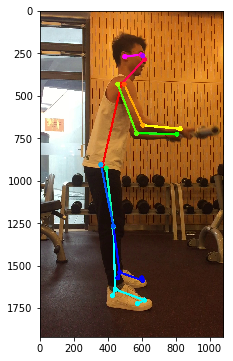

~~~~~~~~~~~~~~~~~~~~~~


In [12]:
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 6.0)
for each_x in range(len(seperate_points)-1):
    print("In the "+ str(each_x+1) +" turn, you have several problems:")
    feedback = feedbacks[each_x]
    image_part = feedbacks_image[each_x]
    if feedback == ['None','None','None']:
        print('Good Jobs!!!!!')
    else:
        for each_y in range(len(feedback)):
            if feedback[each_y] != 'None':
                
                if image_part[each_y] != 'None':
                    print('\033[1;35m',feedback[each_y])
                    #print(image_part[each_y])
                    
                    img = cv2.imread(image_part[each_y])
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.imshow(img)
                    plt.show()
                else:
                    print(feedback[each_y])

    print('~~~~~~~~~~~~~~~~~~~~~~')

In [ ]:
# now using the Dynamic time warping to compare the similarity to the standard action
# the above action part(theta list) is stored in whole_actions
#np.savetxt('a.txt',a,fmt='%0.8f')
#for x in whole_actions:
#print(len(whole_actions))
#for i in range(len(whole_actions)):
#    name = 'barbell_template/test'+str(i+23)+'.txt'
#    np.savetxt(name, whole_actions[i])